# NICO2AI Reinforcement Learning I Practice

## Grid World with Q Learning
Grid World is a 2D environment described as 2D matrix. OpenAI Gym also provides a kind of grid world named FrozenLake with 4x4 matrix. But it is stochastic environment which is not effective to learn Q learning. So we have original grid world with the same interface as Gym. The objective of this world is getting to the goal with avoiding holes which give the negative reward. Let's see the reinforcement learning settings.

- state: integer value representing position in the grid (0~15)
- reward: integer value representing reward (0/1/-1)
- action: integer value representing direction to move (0~3)
- value: Q value represented by state-action table

In addition, to make things more interesting, let's add small negative reward at each time step and change the value to see how it affects performance.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output

class GridWorld:
    def __init__(self):
        self.grid = [
            ['s', 's', 's', 's'],
            ['s', 'h', 's', 'h'],
            ['s', 's', 's', 'h'],
            ['h', 's', 's', 'g']
        ]
        self.position = 0
    
    def reset(self):
        self.position = 0
        return 0
    
    def step(self, action):
        if action == 0 and (self.position + 1) % 4 != 0:
            self.position += 1
        elif action == 1 and self.position % 4 != 0:
            self.position -= 1
        elif action == 2 and self.position < 12:
            self.position += 4
        elif action == 3 and self.position > 4:
            self.position -= 4
        obj = self.grid[int(self.position / 4)][self.position % 4]
        if obj == 's':
            reward = 0
        elif obj == 'h':
            reward = -1
        elif obj == 'g':
            reward = 1
        done = obj == 'g' or obj == 'h'
        return self.position, reward, done, self.grid

env = GridWorld()

You have GridWorld environment just like previous bandit exercise. Fill blanks to complete Q learning agent.

In [2]:
class Agent:
    def __init__(self, num_states, num_actions, discount=0.99, lr=0.1, epsilon=0.3):
        self.num_states = num_states
        self.num_actions = num_actions
        self.discount = discount
        self.lr = lr
        self.epsilon = epsilon
        self.table = np.zeros((num_states, num_actions), dtype=np.float32)
    
    def act(self, state, greedy=False):
        # epsilon-greedy action selection
        if not greedy and random.random() < self.epsilon:
            return np.random.choice(self.num_actions)
        return np.argmax(self.table[state])
    
    def learn(self, state, action, reward, next_state, done):
        q = self.table[state][action]
        # next_q should be zero when the end of episode
        next_q = np.max(self.table[next_state]) * (0 if done else 1)
        td_error = reward + self.discount * next_q - q
        self.table[state][action] += self.lr * td_error
        return td_error
    
    def reset(self):
        self.table = np.zeros_like(self.table, dtype=np.float32)
    
    def render_table(self):
        plt.imshow(self.normalize_table() * 255.0)
    
    def render_path(self):
        plt.imshow(np.max(self.normalize_table(), axis=1).reshape(4, 4))
    
    def normalize_table(self):
        table = self.table - np.min(self.table)
        table = table / np.max(table)
        return table

Now you have learnable agent with Q learning. Then let's train it!

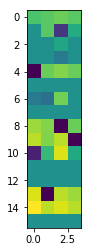

In [3]:
# change these values later
discount = 0.9
lr = 0.1
epsilon = 0.3
step_reward = -0.01

agent = Agent(16, 4, discount, lr, epsilon)

rewards = []
for i in range(1000):
    state = env.reset()
    last_state = None
    sum_of_reward = 0
    while True:
        last_state = state
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        reward += step_reward
        agent.learn(last_state, action, reward, state, done)
        sum_of_reward += reward
        if done:
            break
    rewards.append(sum_of_reward)

# plot q table
agent.render_table()

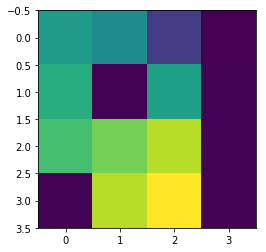

In [4]:
# plot max action values
agent.render_path()

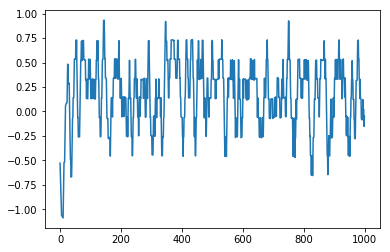

In [5]:
# plot moving average of rewards
plt.plot(np.arange(1000), np.convolve(rewards, np.ones(10) / 10, mode='same'))

You get expected results? If yes, change `discount`, `lr`, `epsilon` and `step_reward` to see how they affect performance and state-action table.

## CartPole with Q Learning
CartPole is the well-known task that you control the cart to keep pole upright. First of all, run the following code to see CartPole animation.

[2017-08-20 19:01:23,474] Making new env: CartPole-v0



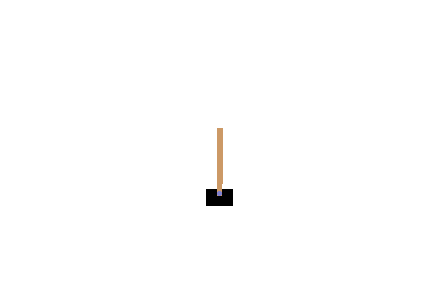
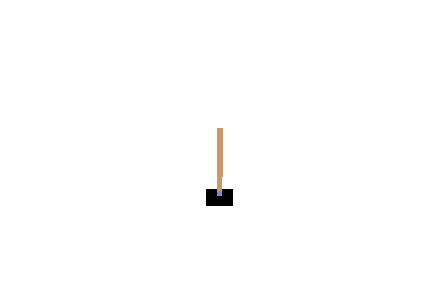
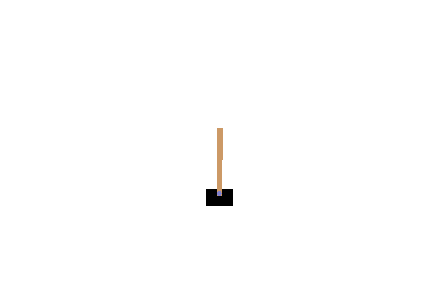
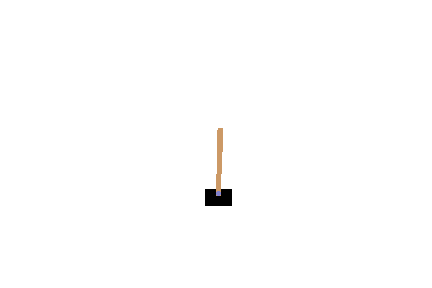
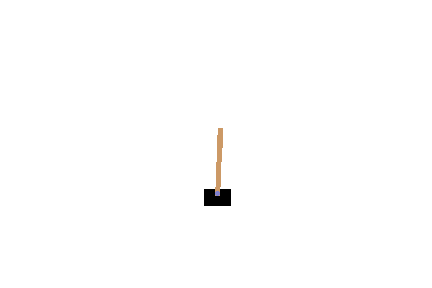
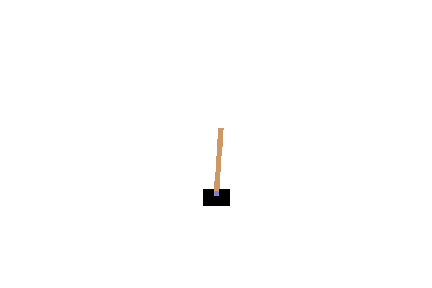
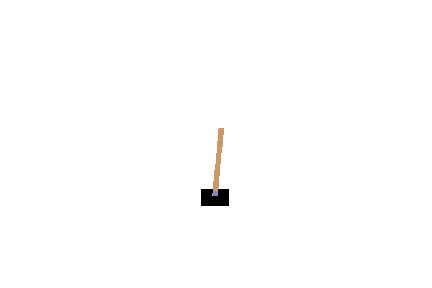
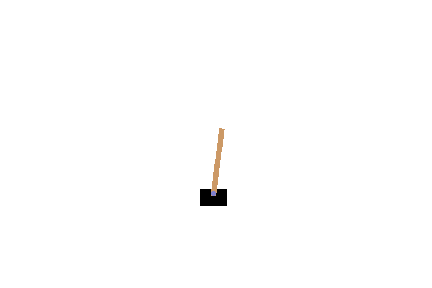
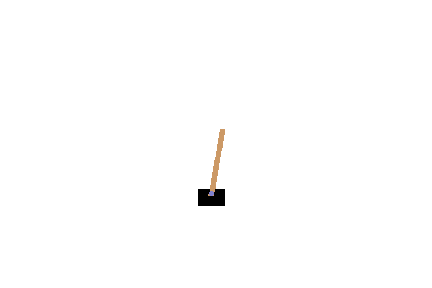

In [6]:
import gym
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

## util function to render CartPole as GIF image
def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

env = gym.make('CartPole-v0')
env.reset()
frames = []
while True:
    frames.append(env.render(mode='rgb_array'))
    _, _, done, _ = env.step(0)
    if done:
        break
env.render(close=True)
display_frames_as_gif(frames)

CartPole is offered by OpenAI Gym. RL agent should feed +1 or -1 to the cart. A reward of +1 is provided for every timestep while the pole remains upright. The episode ends when the pole is more than 15 degrees from vertival, or the cart moves more than 2.4 units from the center. In this environemnt, reinforcement learning setting is described as below.

- state: array with 4 elements representing (horizontal coordinate, horizontal velocity, pole angle, pole angular velocity)
- action: integer value representing direction to push the cart (0/1)
- reward: +1 for every timestep
- value: Q value represented by state-action table

The difference between GridWorld and CartPole is that state is continuous, not discrete (0.1, 0.001, 0.0001, ...). To deal with this problem, discretize state space by using `np.linspace(start, stop, num)` and `np.digitize(x, bins)`. `np.linspace(start, stop, num)` returns values between `start` and `stop` divided into `num`. `np.digitize(x, bins)` returns index which satisfies `bins[index - 1]` =< `x` < `bins[index]`. Let's make state transformation.

In [7]:
# change these values later
horizontal_position_num = 2
horizontal_velocity_num = 10
pole_angle_num = 50
pole_angular_velocity_num = 20

horizontal_position_bins = np.linspace(-2.4, 2.4, horizontal_position_num)
horizontal_velocity_bins = np.linspace(-2.0, 2.0, horizontal_velocity_num)
pole_angle_bins = np.linspace(-0.4, 0.4, pole_angle_num)
pole_angular_velocity_bins = np.linspace(-3.5, 3.5, pole_angular_velocity_num)

def discretize(state):
    discretized_state = [
        np.digitize(state[0], horizontal_position_bins),
        np.digitize(state[1], horizontal_velocity_bins),
        np.digitize(state[2], pole_angle_bins),
        np.digitize(state[3], pole_angular_velocity_bins)
    ]
    index = 0
    index += discretized_state[0]
    index += discretized_state[1] * horizontal_position_num
    index += discretized_state[2] * horizontal_velocity_num
    index += discretized_state[3] * pole_angle_num
    return index

Now you can discretize continuous action space. In default settings, state space has the size of 2x10x50x20. Then fill blanks to train agent.

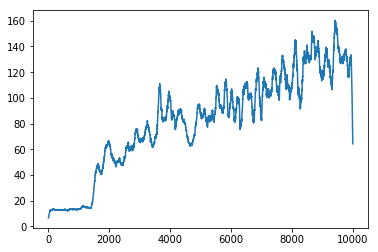

In [8]:
# change these values later
discount = 0.9
lr = 0.1
epsilon = 0.1

num_state = horizontal_position_num *\
        horizontal_velocity_num * pole_angle_num * pole_angular_velocity_num

agent = Agent(num_state, 2, discount, lr, epsilon)

rewards = []
for i in range(10000):
    state = env.reset()
    last_state = None
    sum_of_rewards = 0
    
    while True:
        last_state = state
        action = agent.act(discretize(state))
        state, reward, done, _ = env.step(action)
        agent.learn(discretize(last_state), action, reward, discretize(state), done)
        sum_of_rewards += reward
        if done:
            break
            
    rewards.append(sum_of_rewards)

# this may take a few minutes
plt.plot(np.arange(10000), np.convolve(rewards, np.ones(100) / 100, mode='same'))

If agent is successfully trained, you would see the graph rising to the right. Finally, let's check agent behaviour.


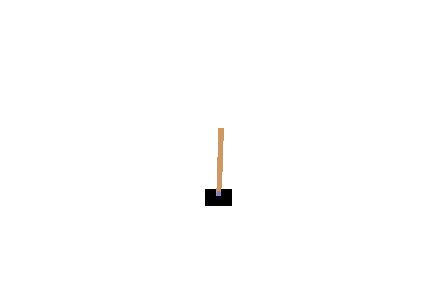
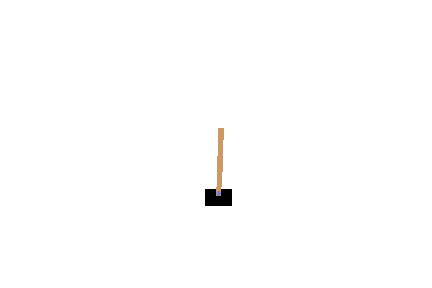
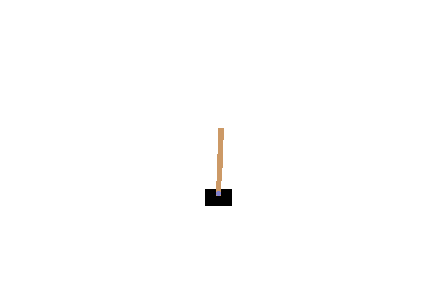
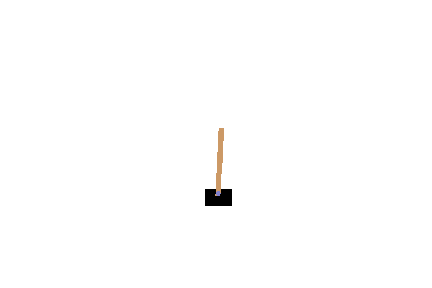
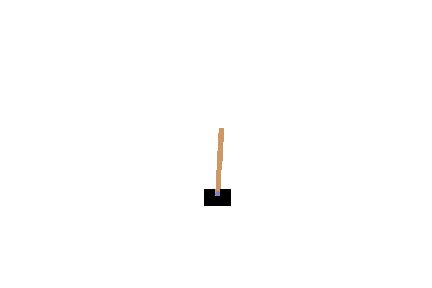
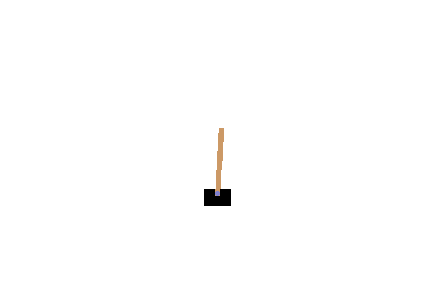
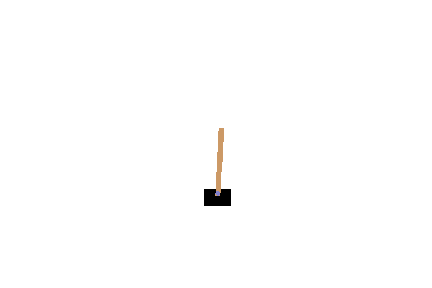
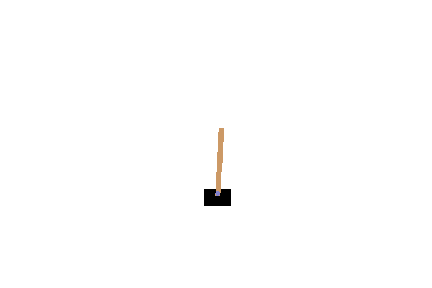
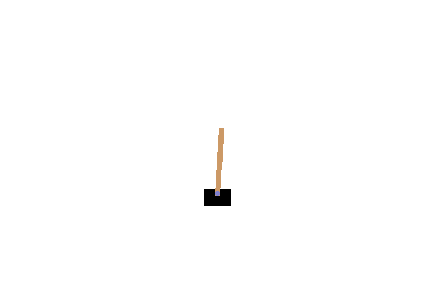
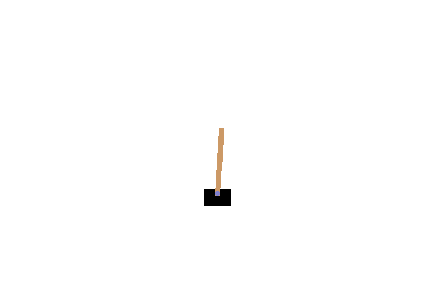
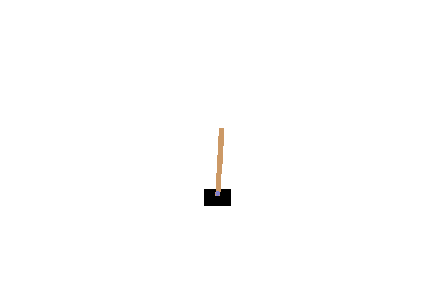
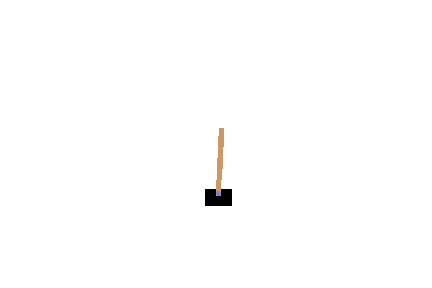
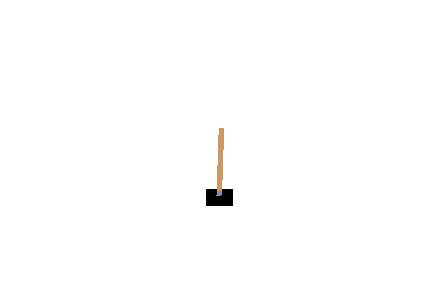
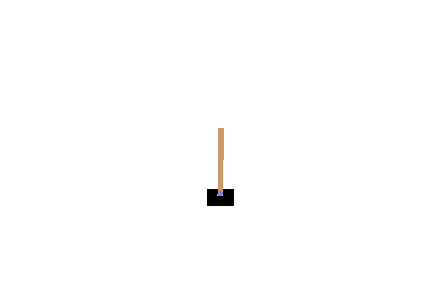
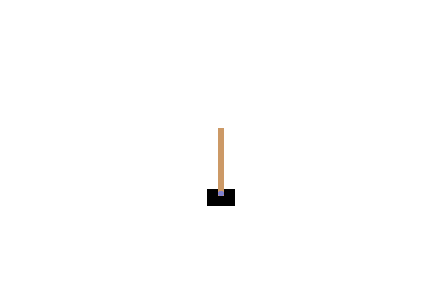
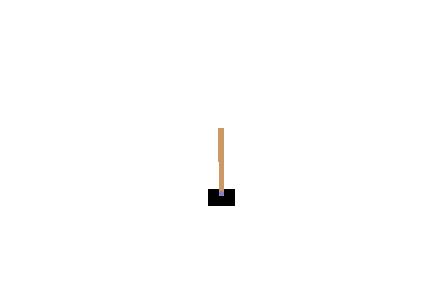
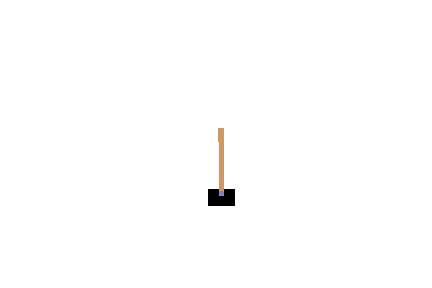
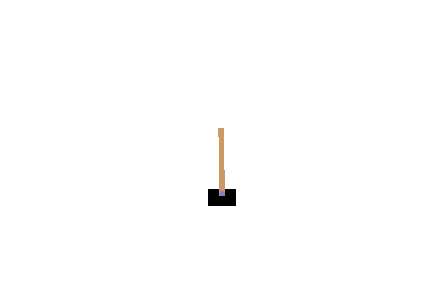
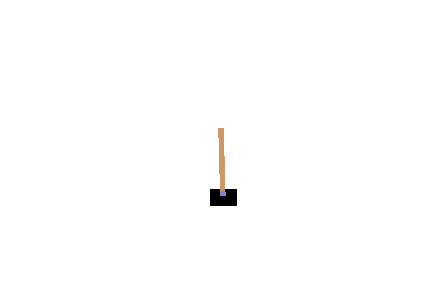
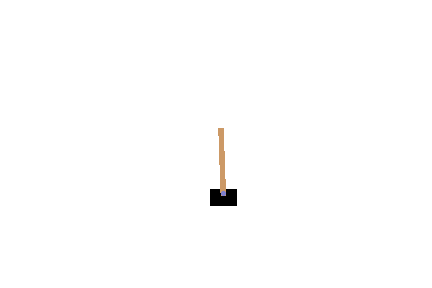
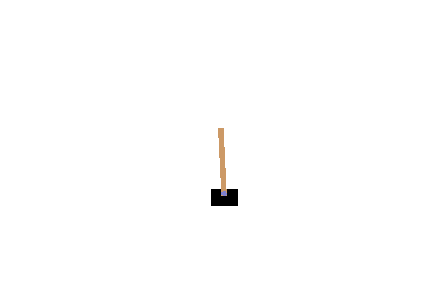
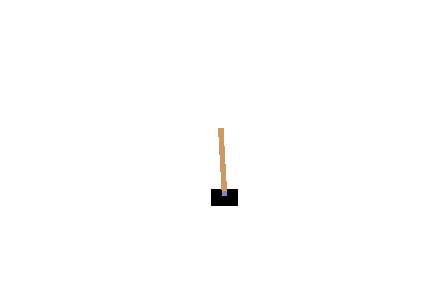
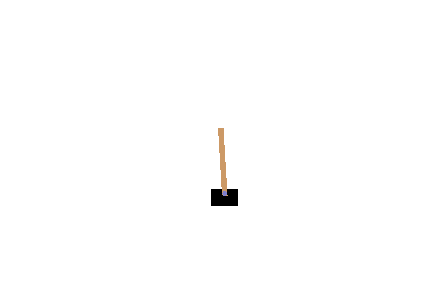
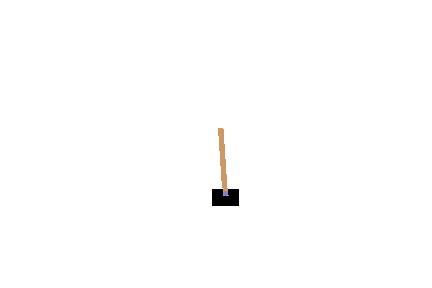
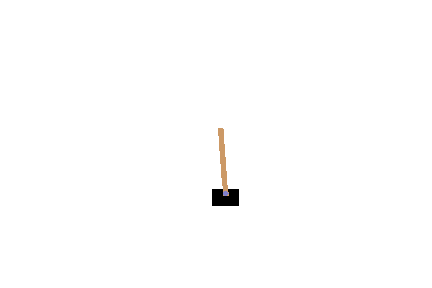
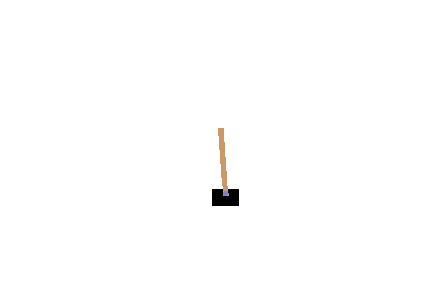
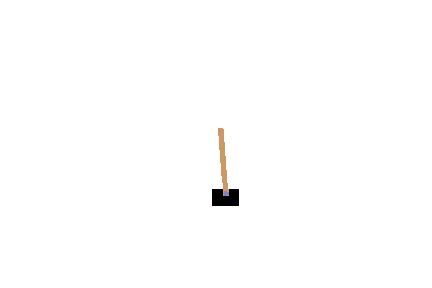
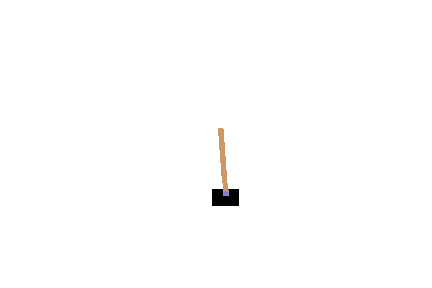
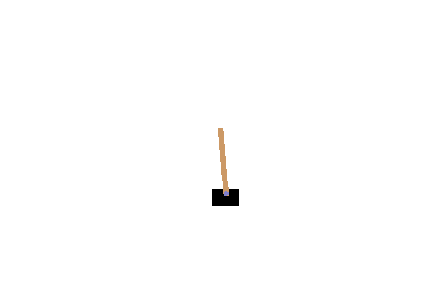
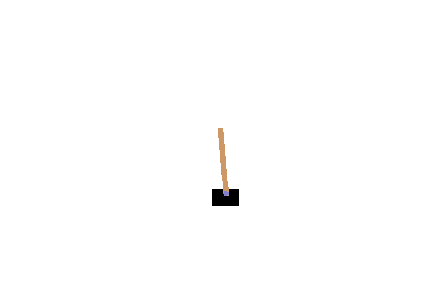
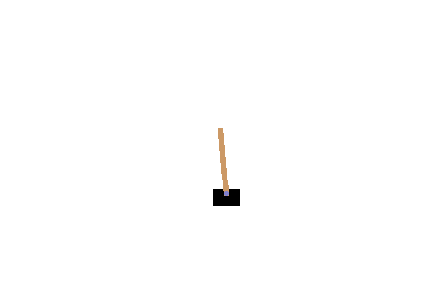
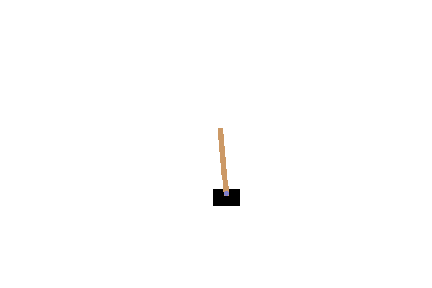
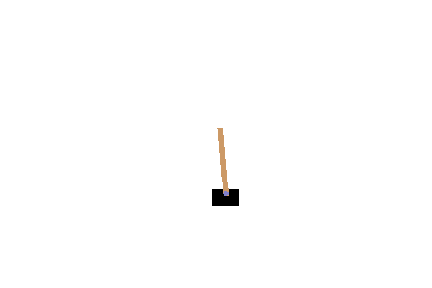
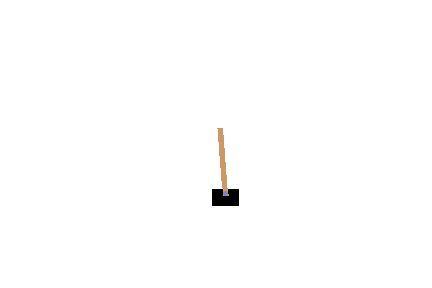
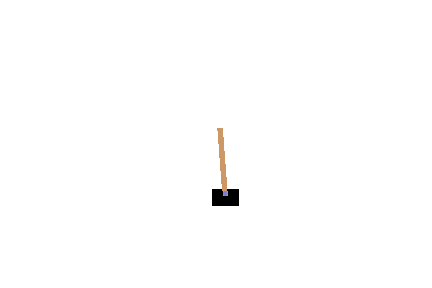
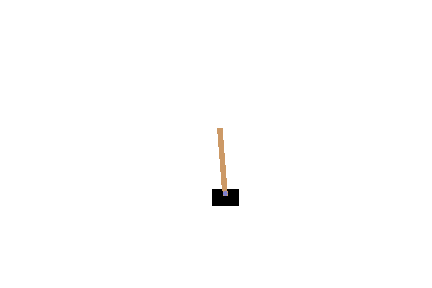
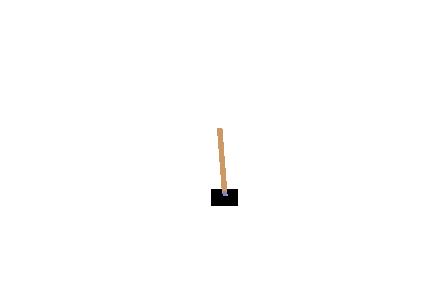
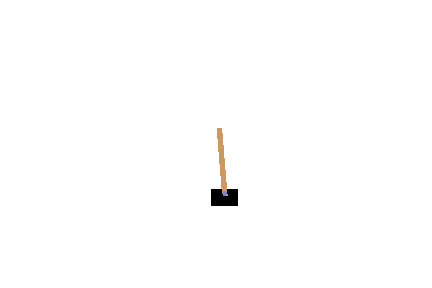
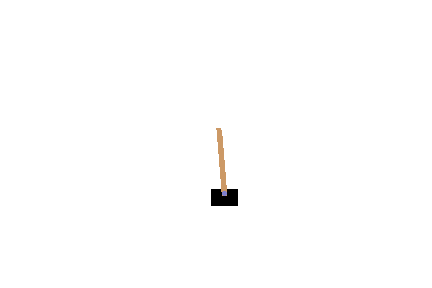
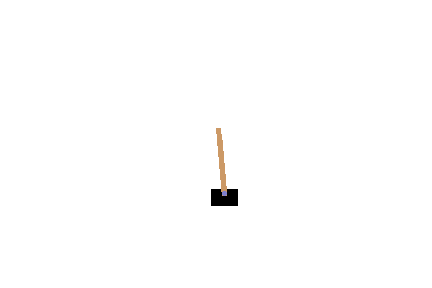
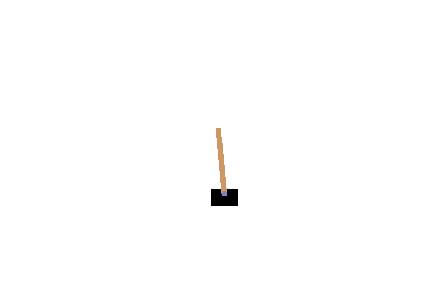
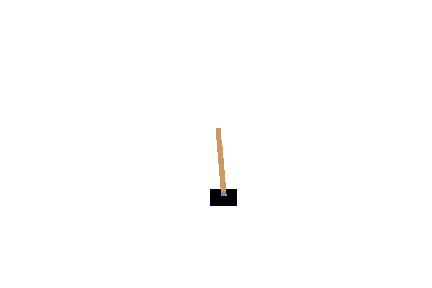
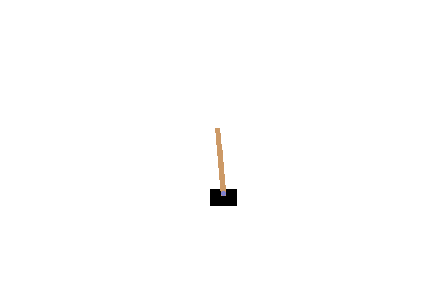
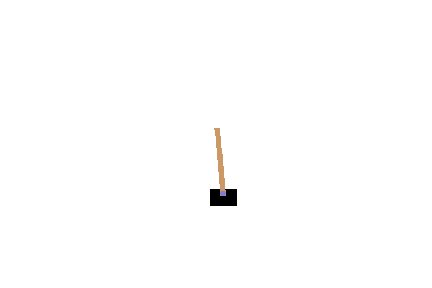
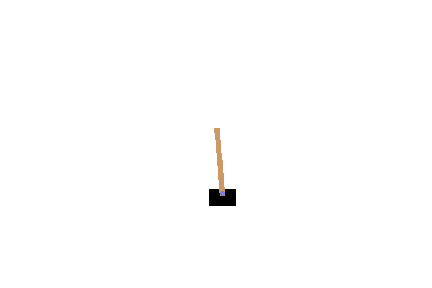
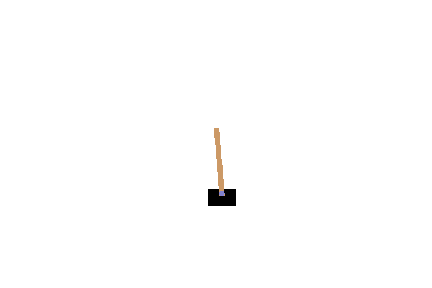
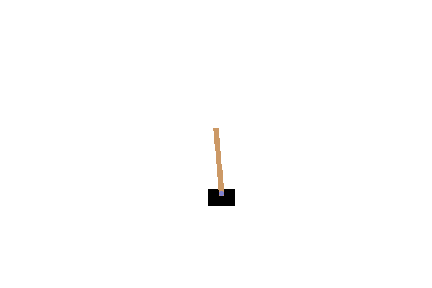
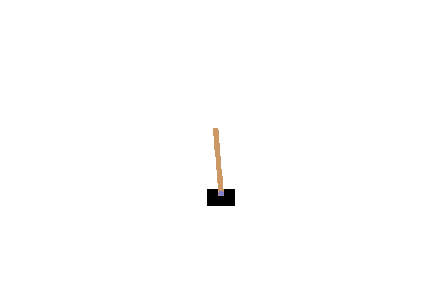
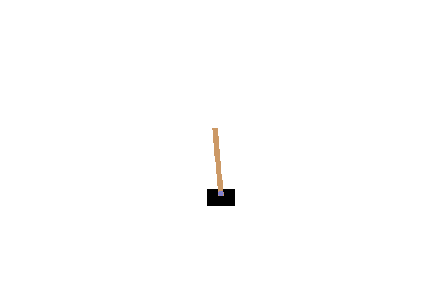
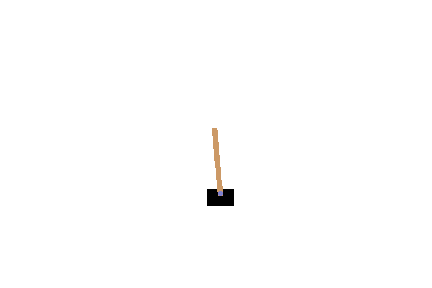
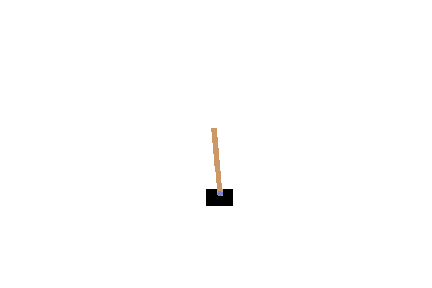
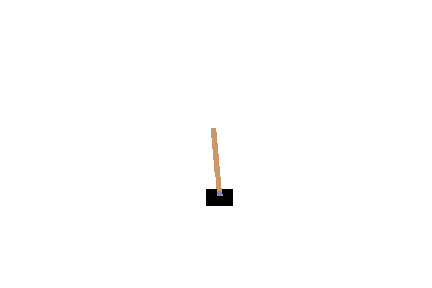
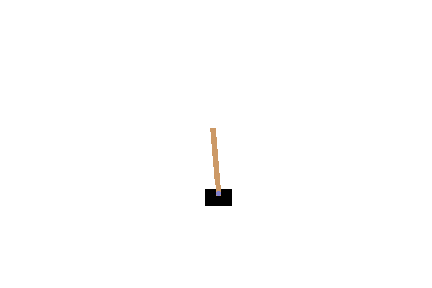
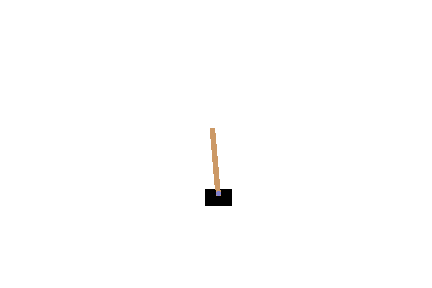
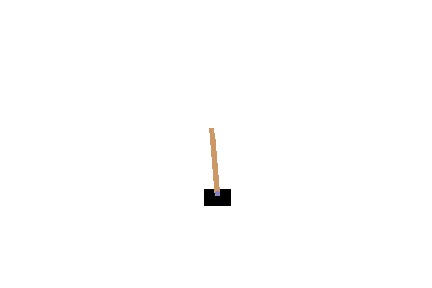
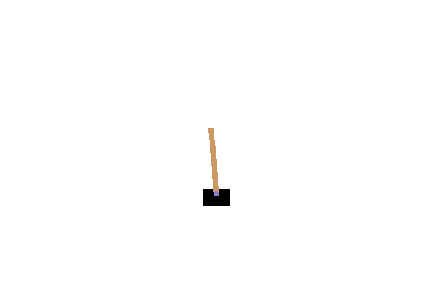
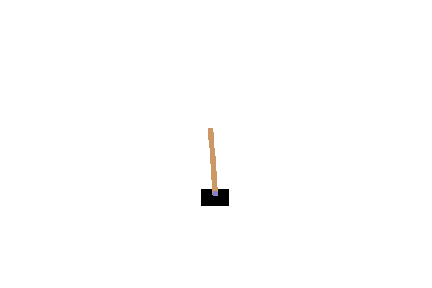
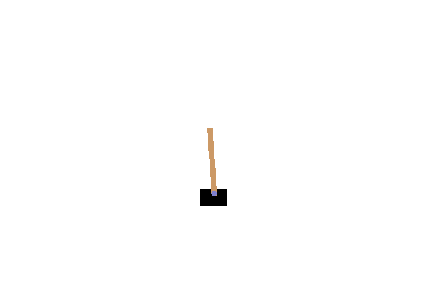
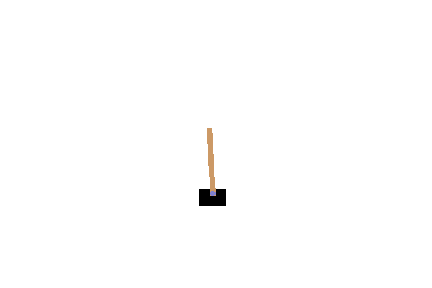
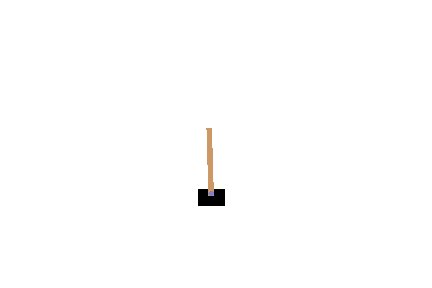
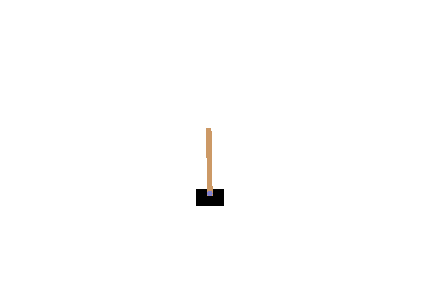
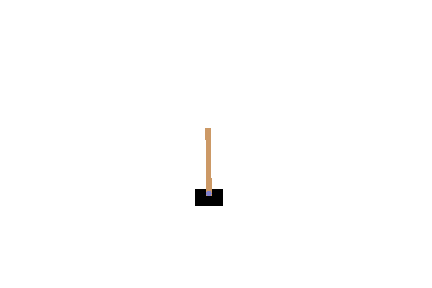
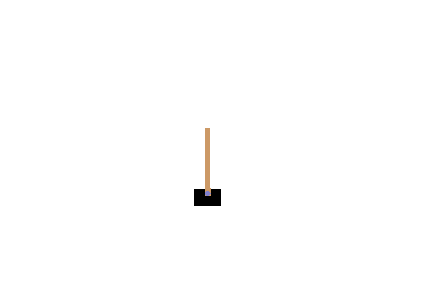
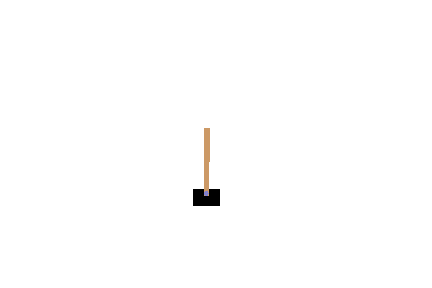
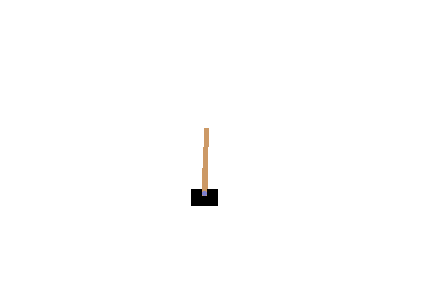
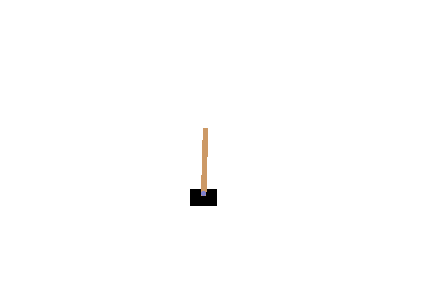
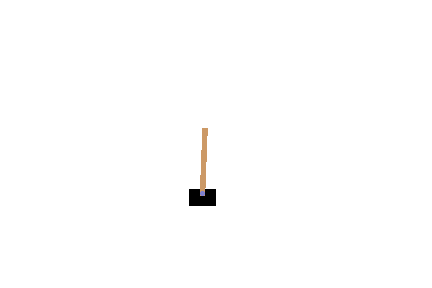
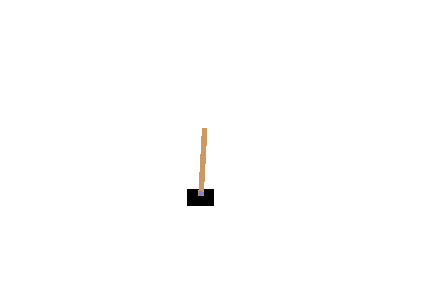
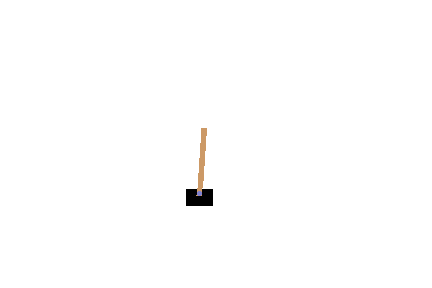
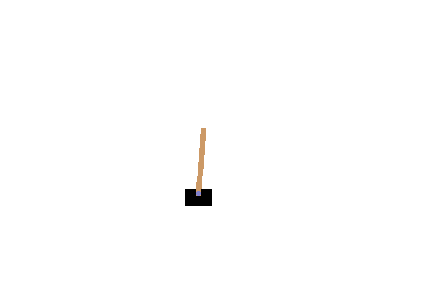
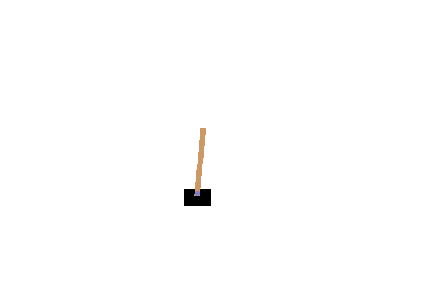
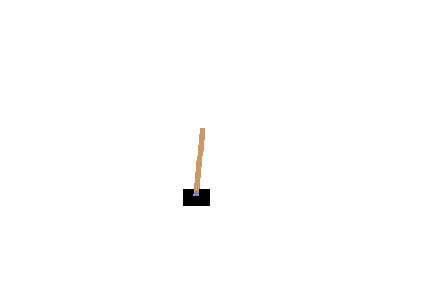
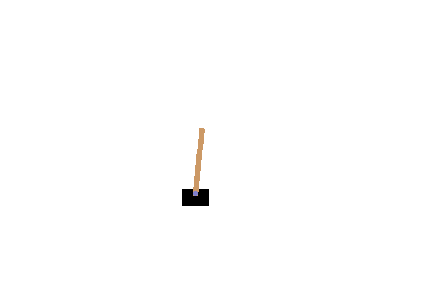
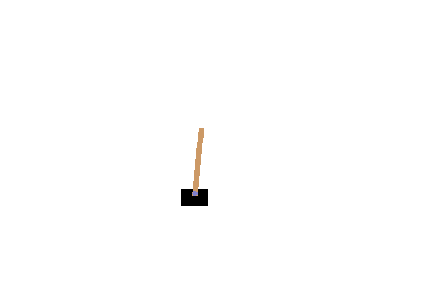
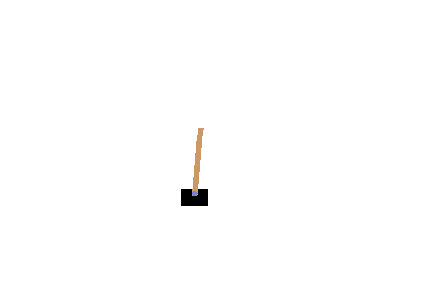
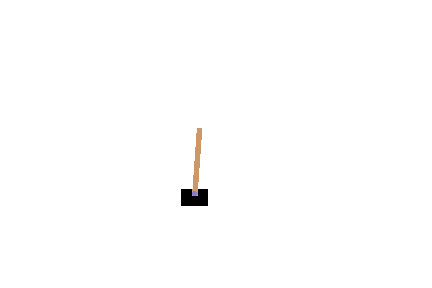
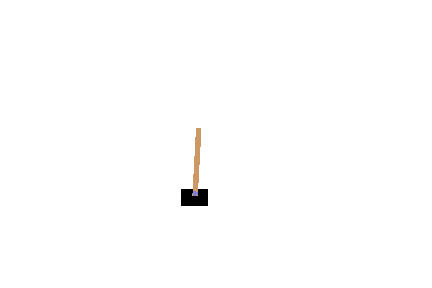
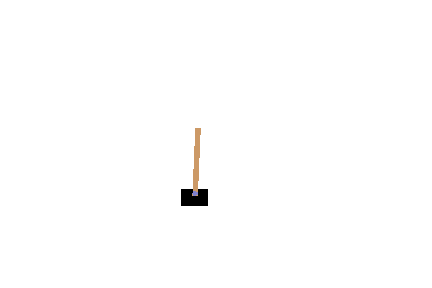
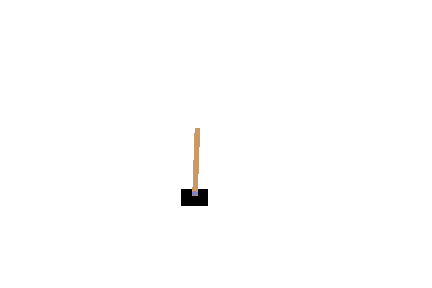
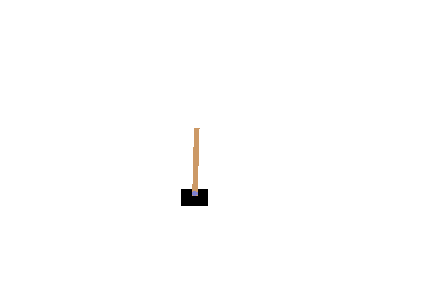
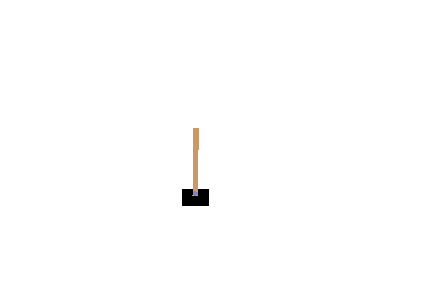
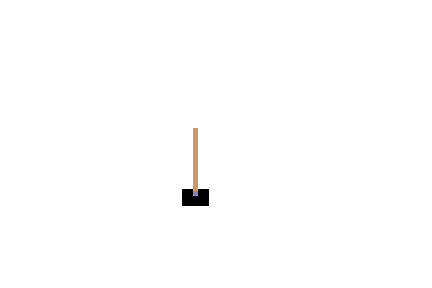
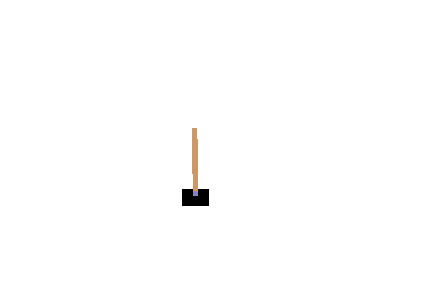
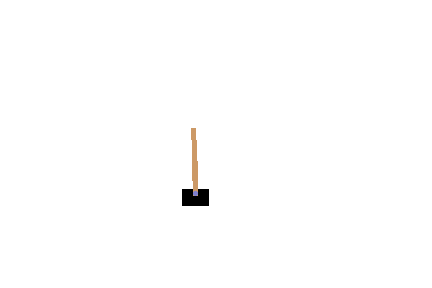
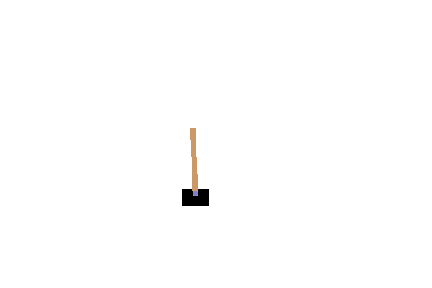
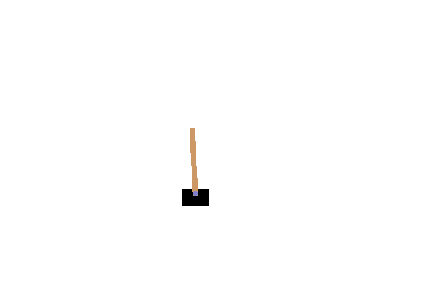
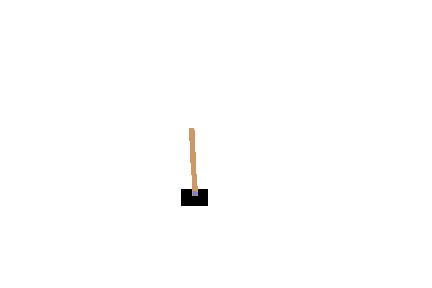
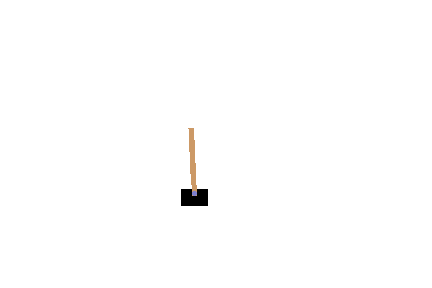
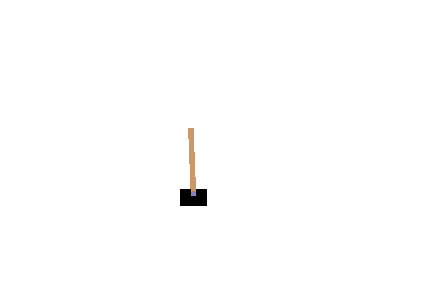
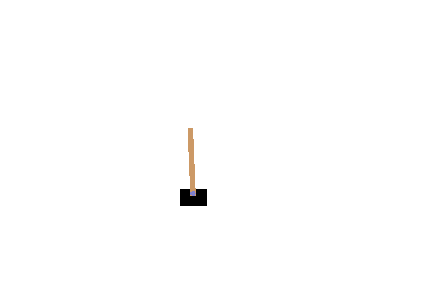
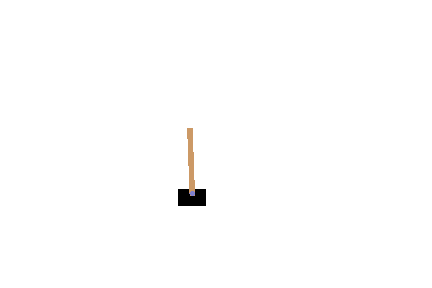
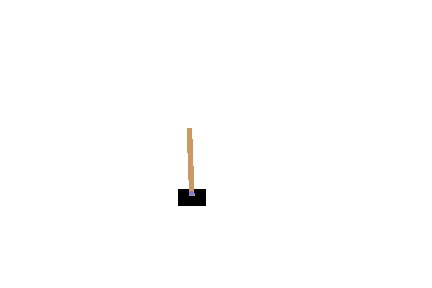
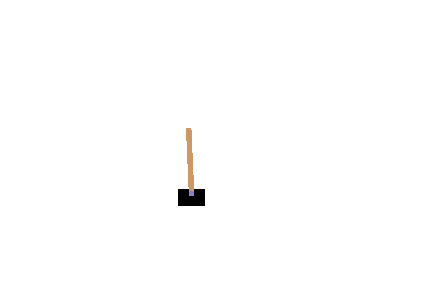
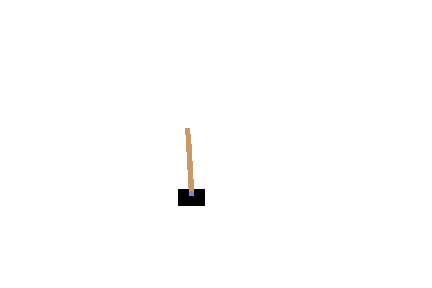
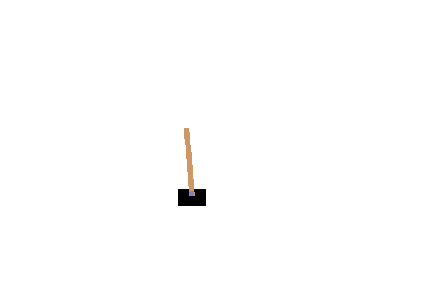
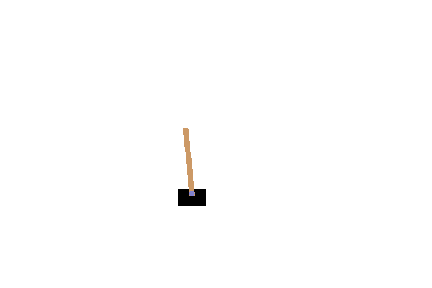
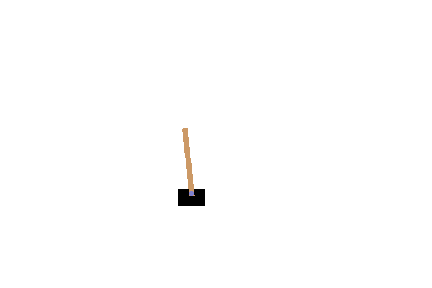
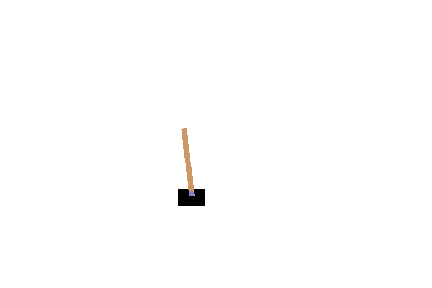
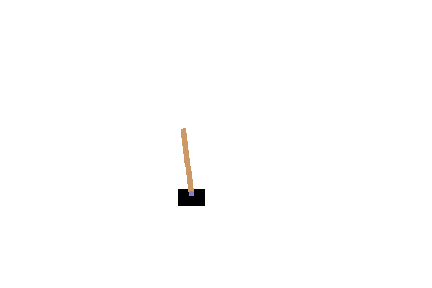
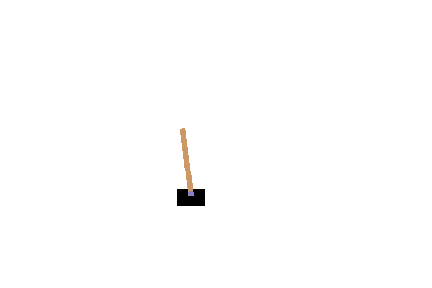
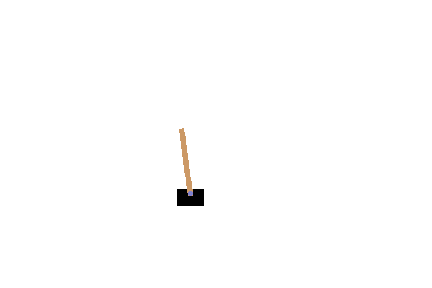
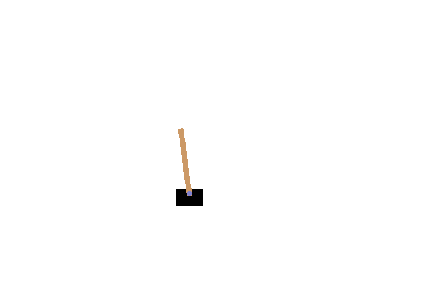
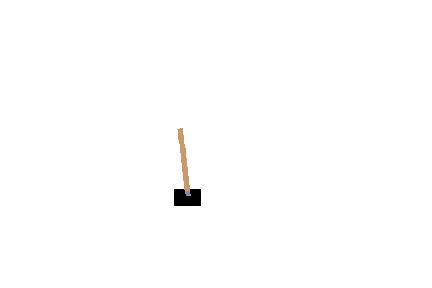
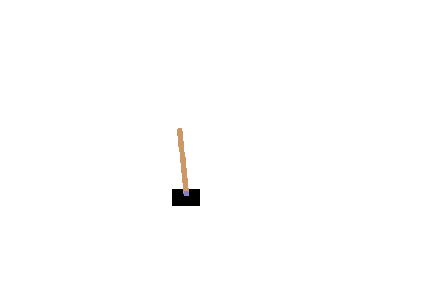
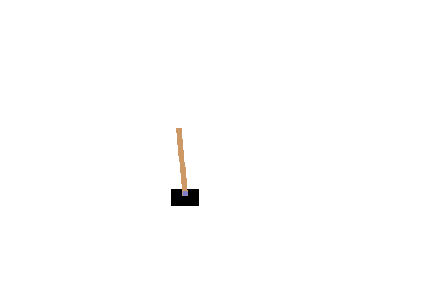
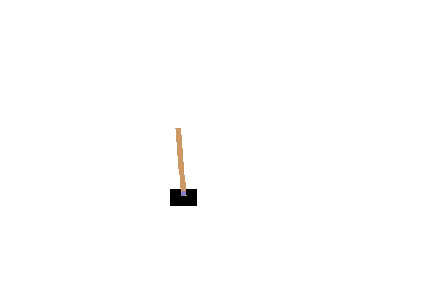
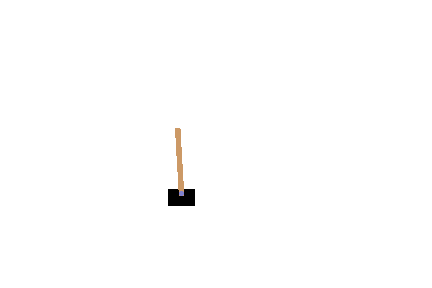
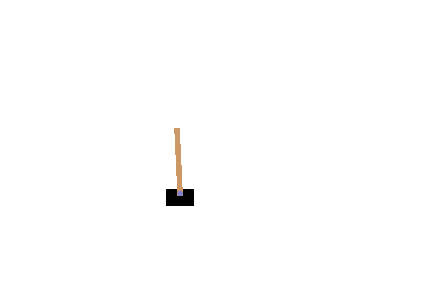
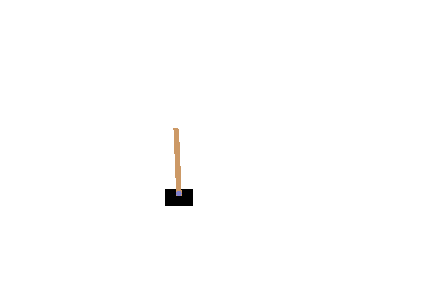
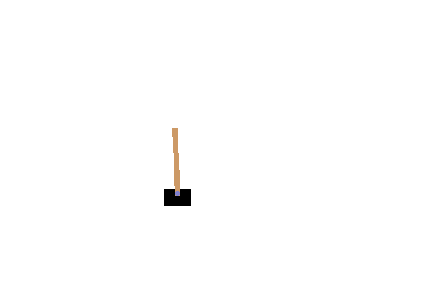
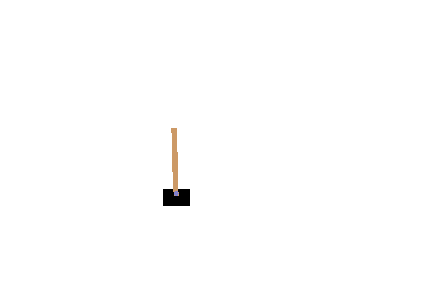
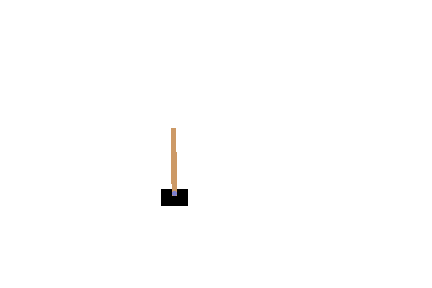
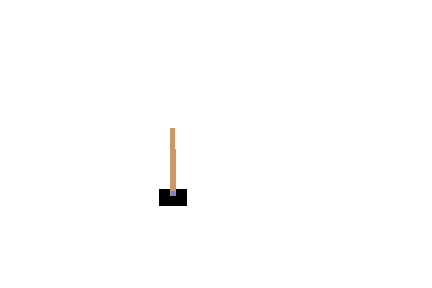
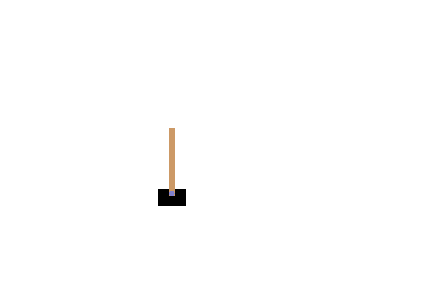
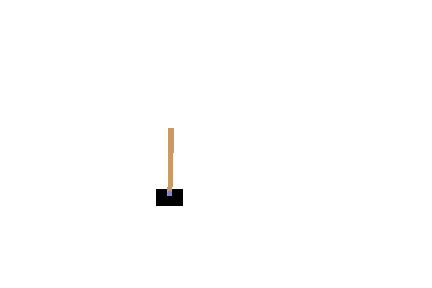
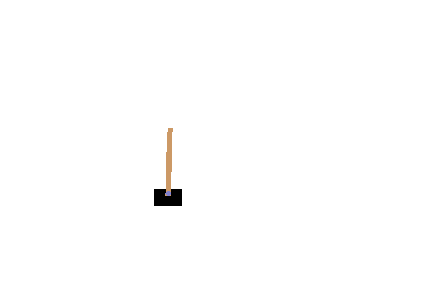
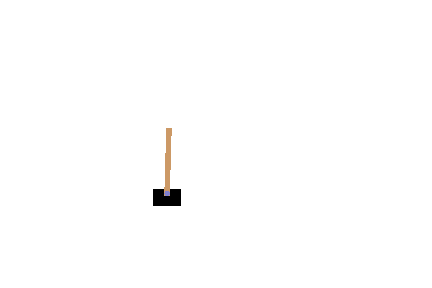
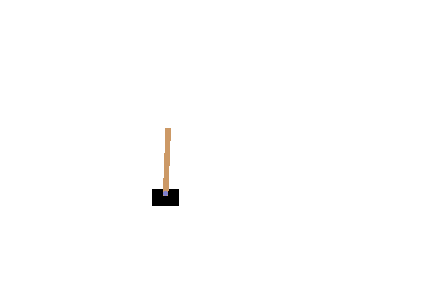
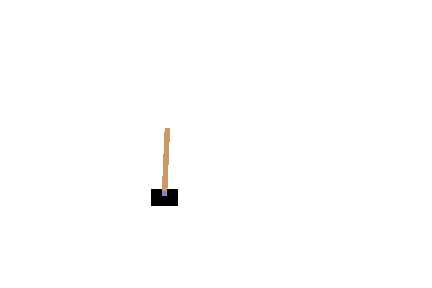
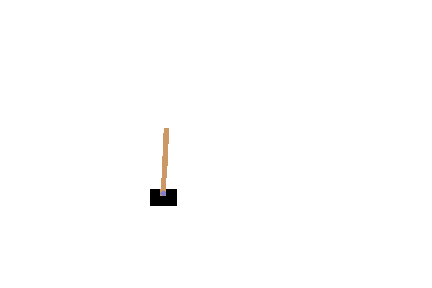
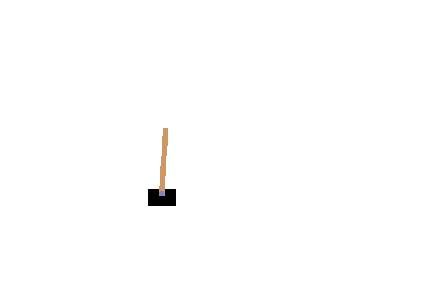
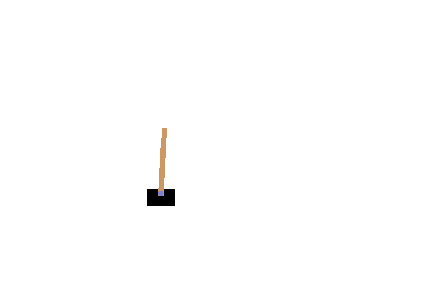
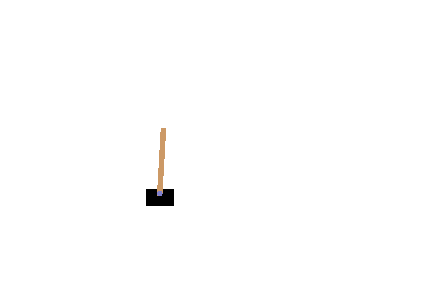
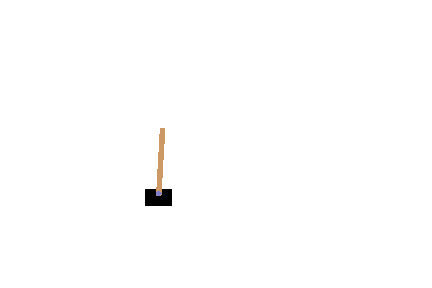
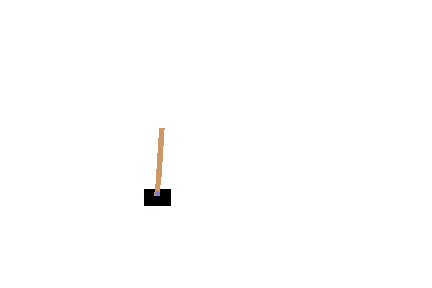
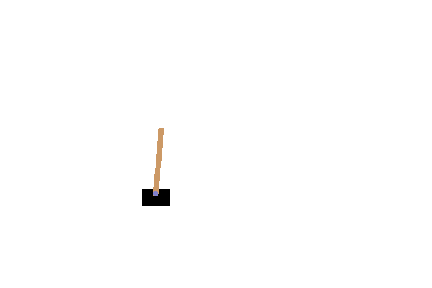
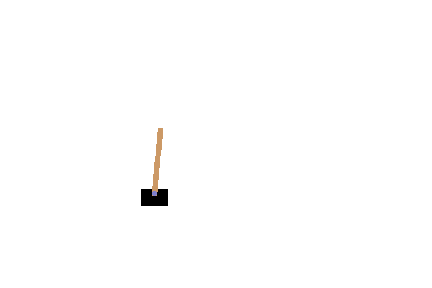
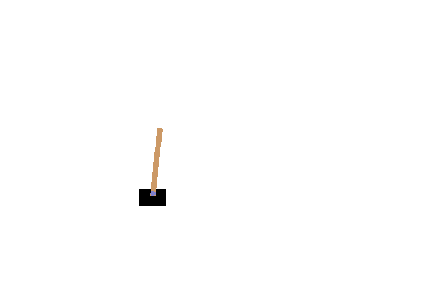
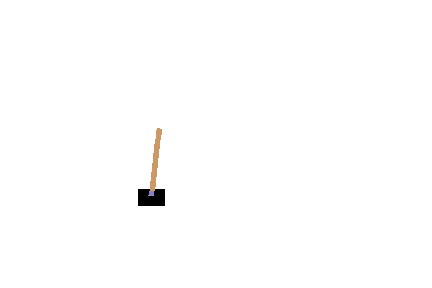
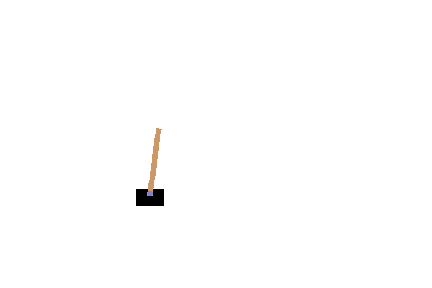
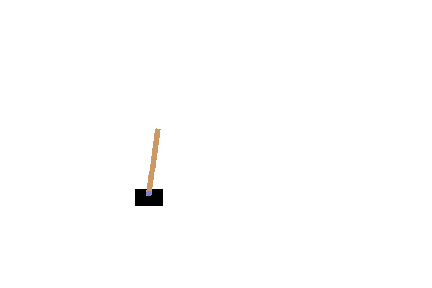
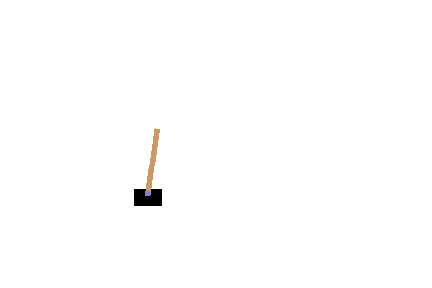
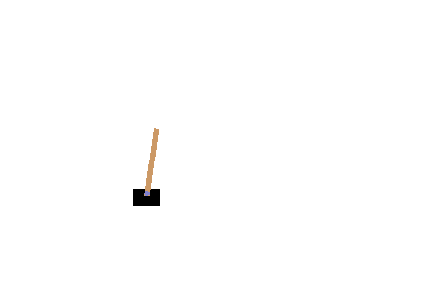
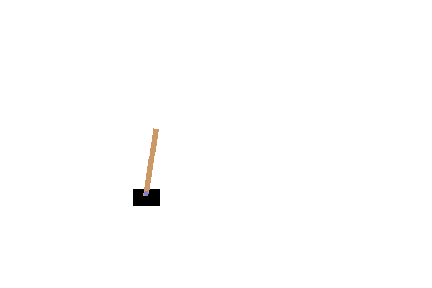
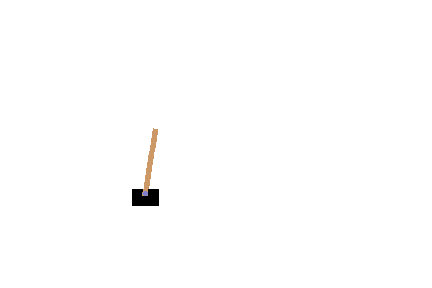
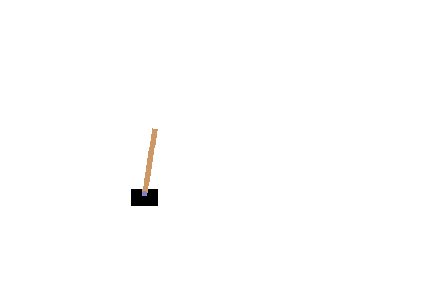
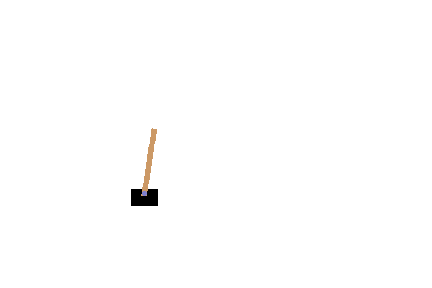
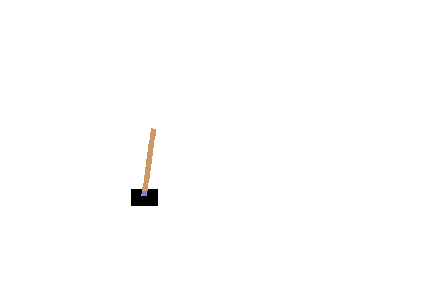
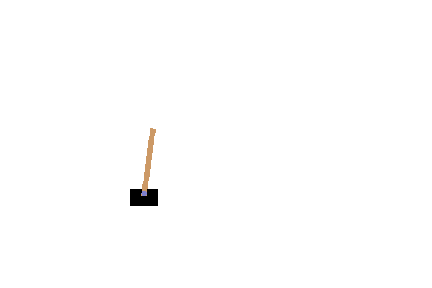
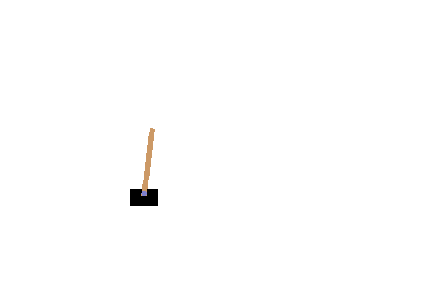
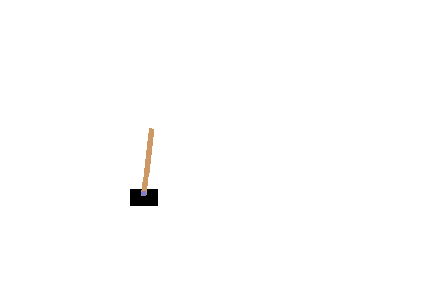
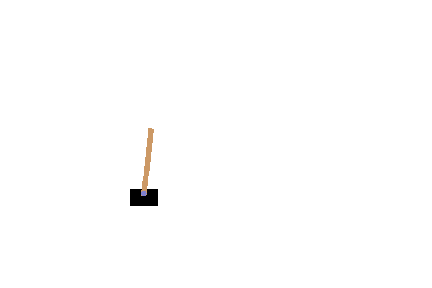
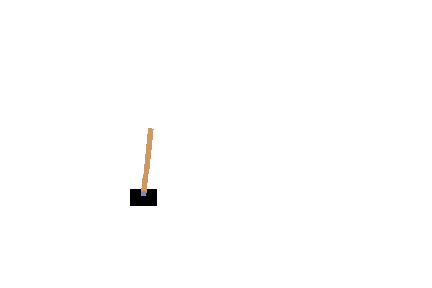
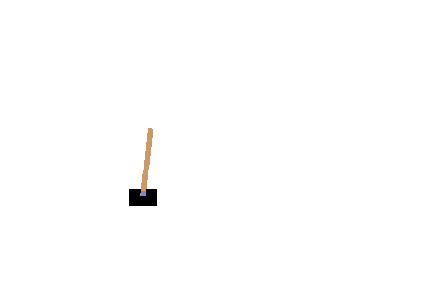
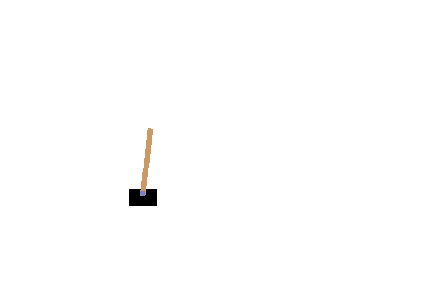
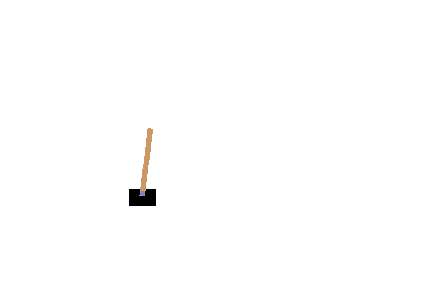
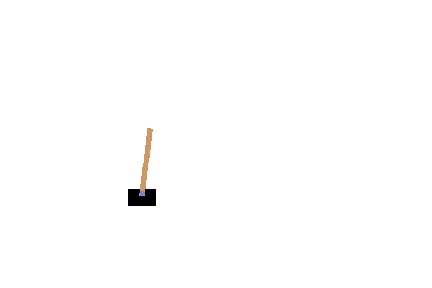
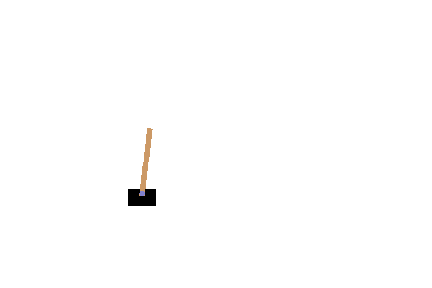
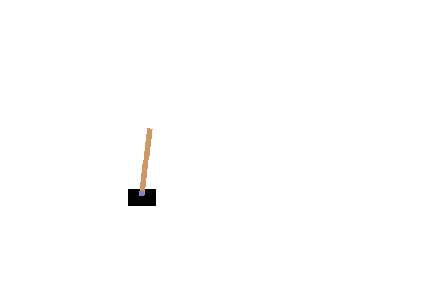
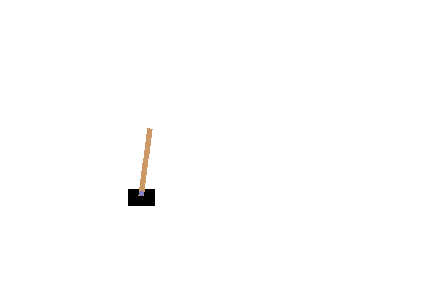
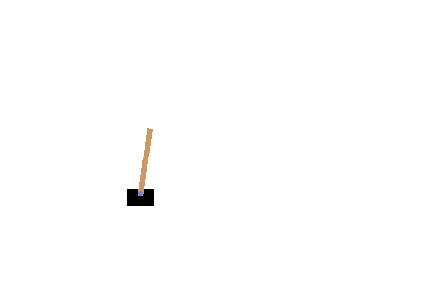
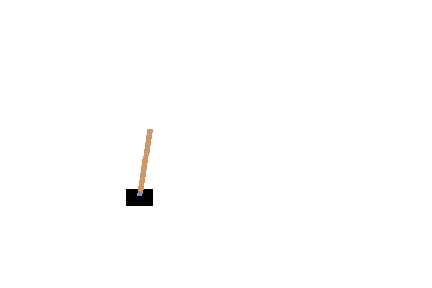
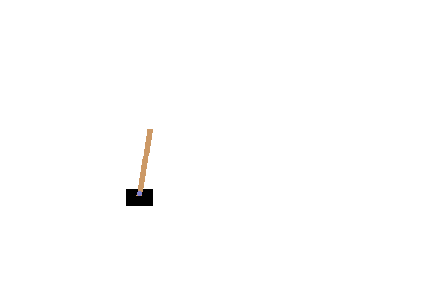
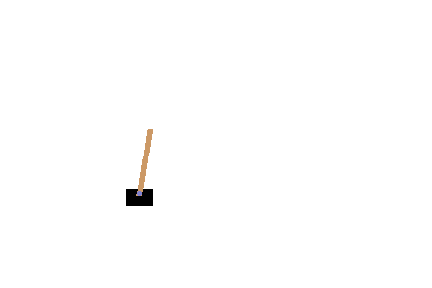
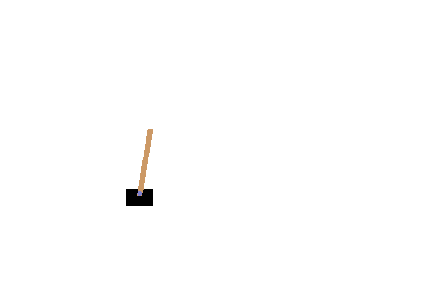
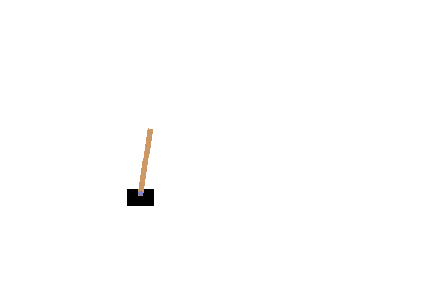
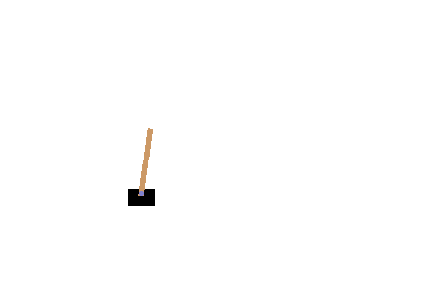
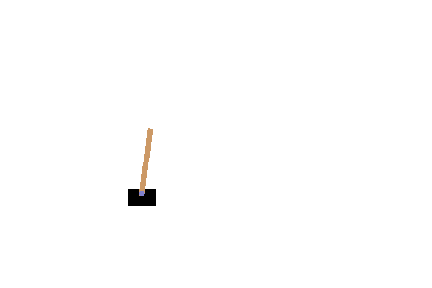
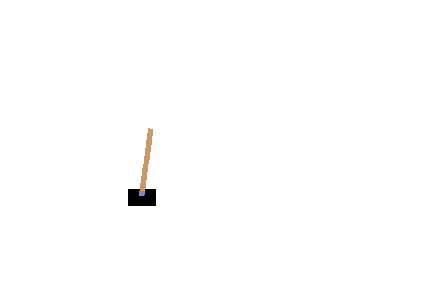
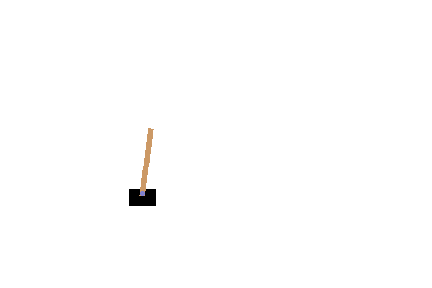
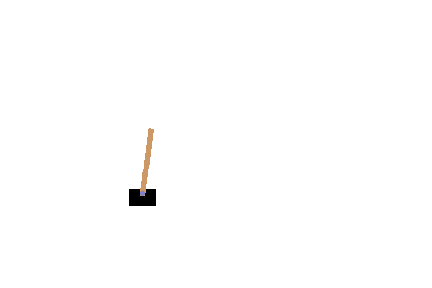
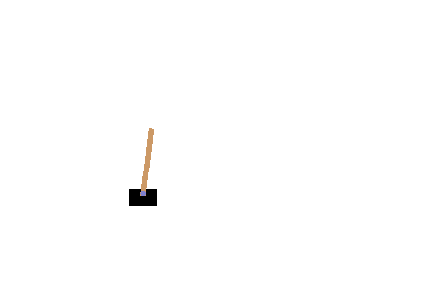
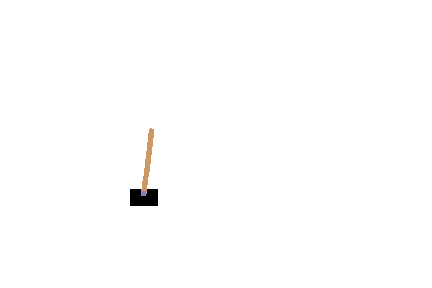
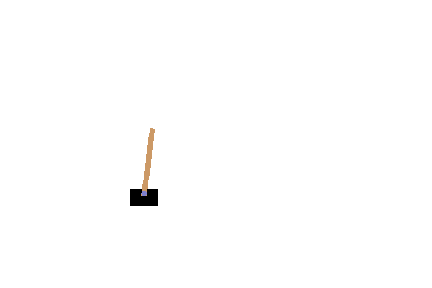
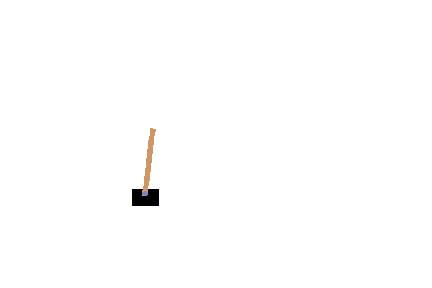
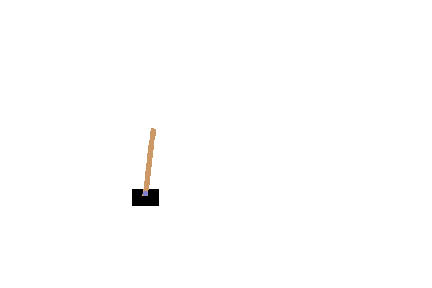
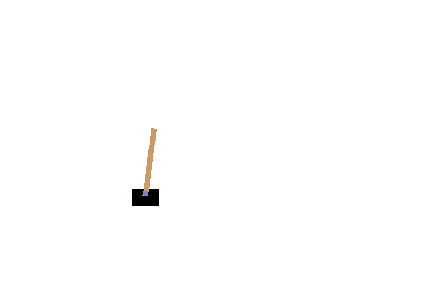
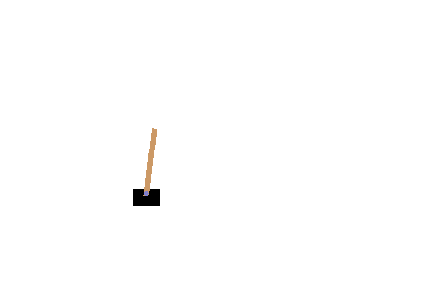
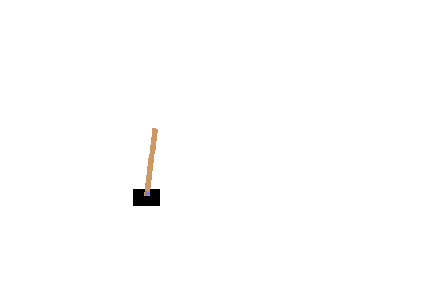
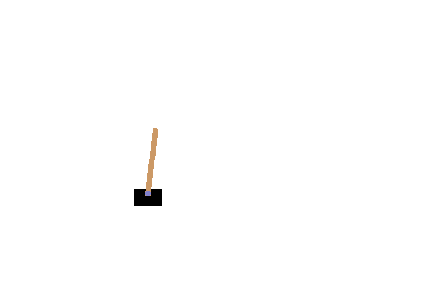
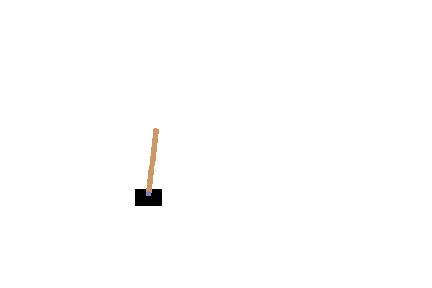
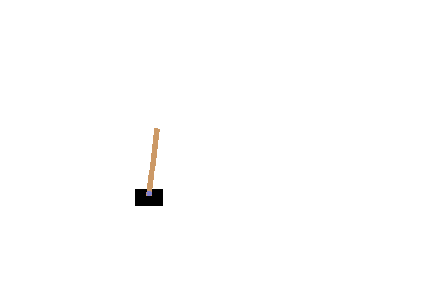
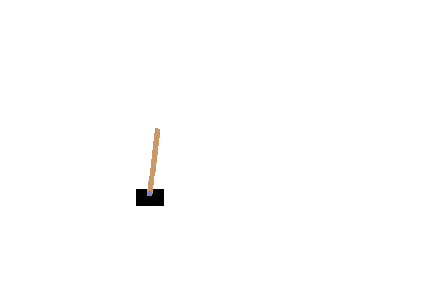
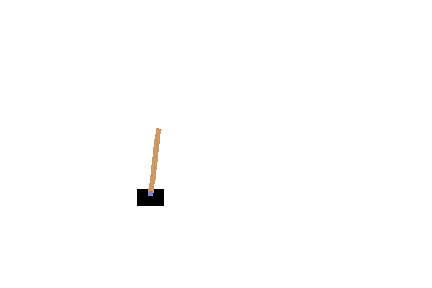
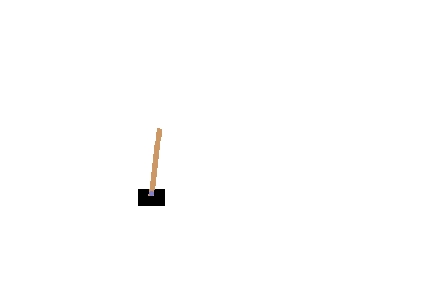
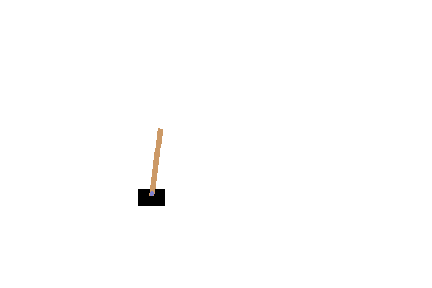
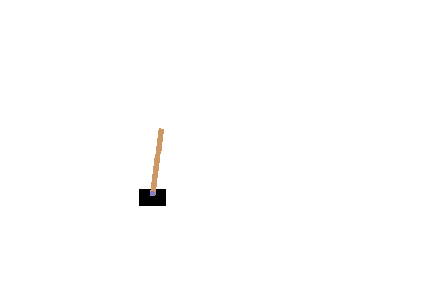
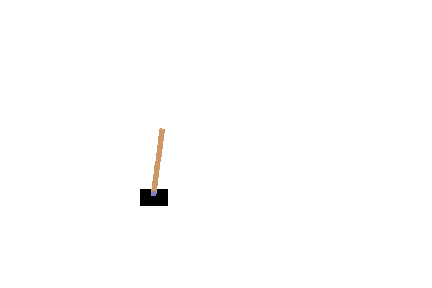
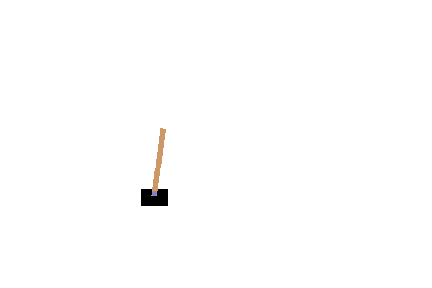
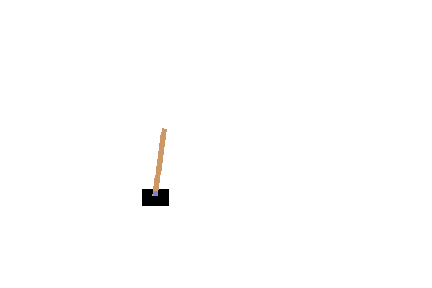
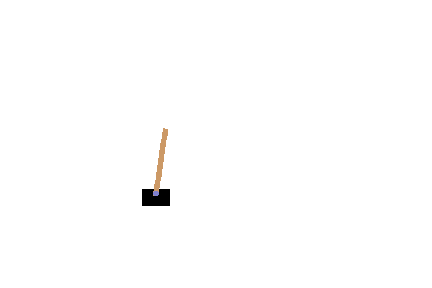
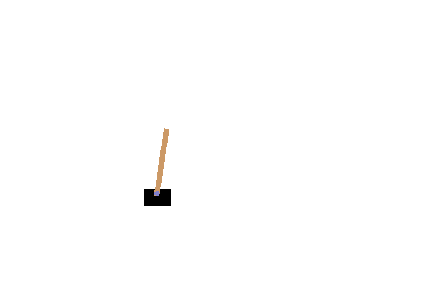
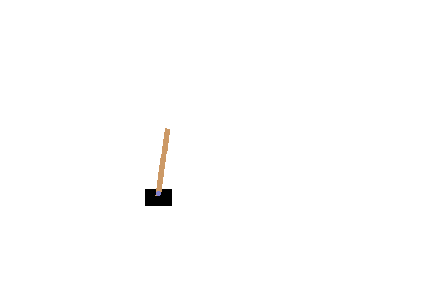
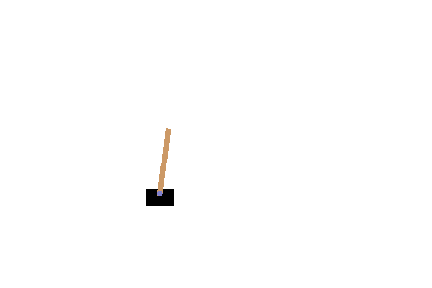
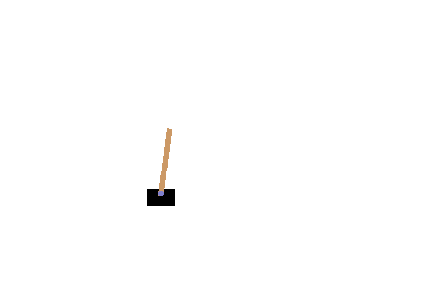
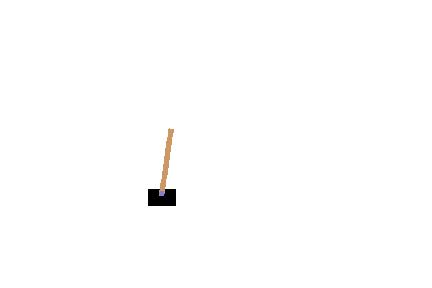
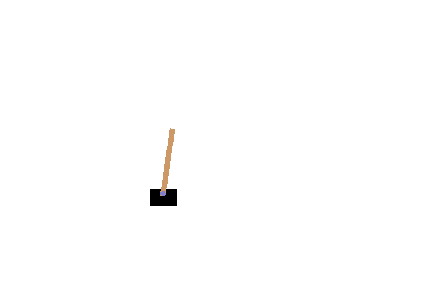
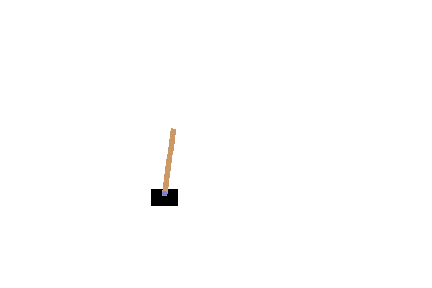
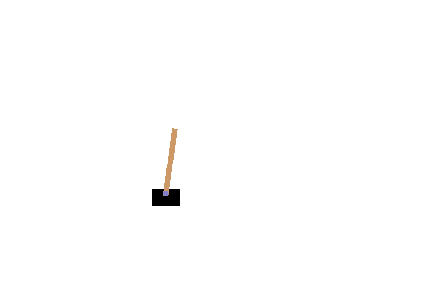
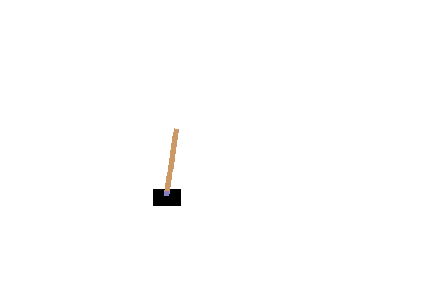
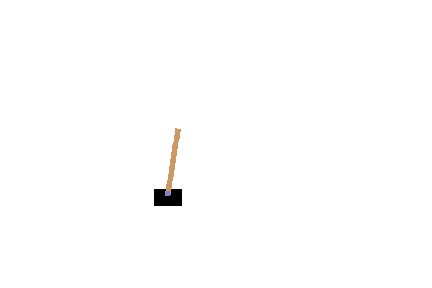
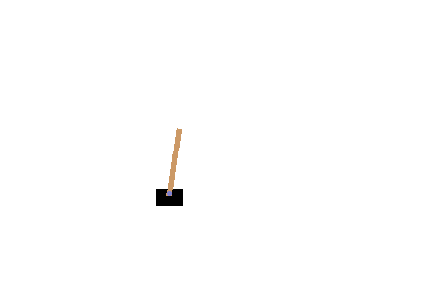
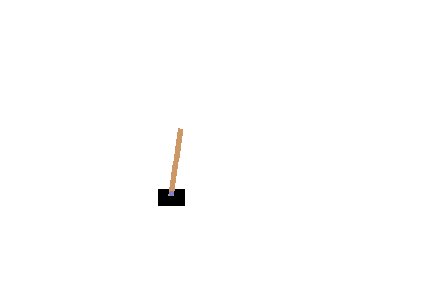
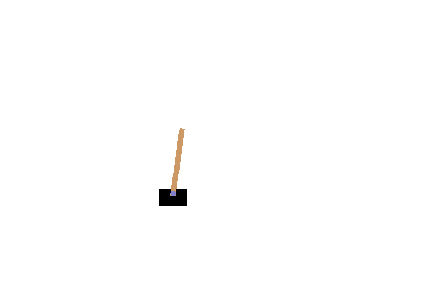
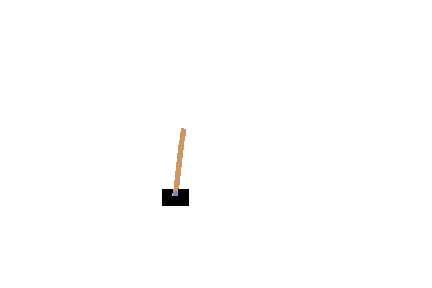
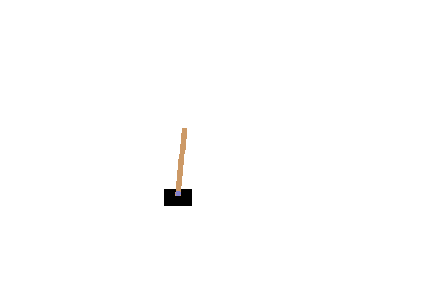
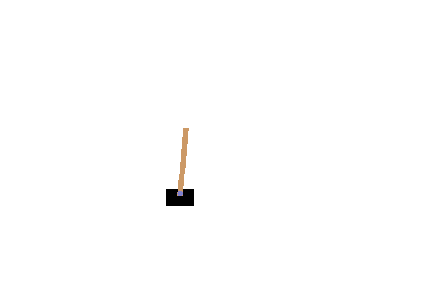
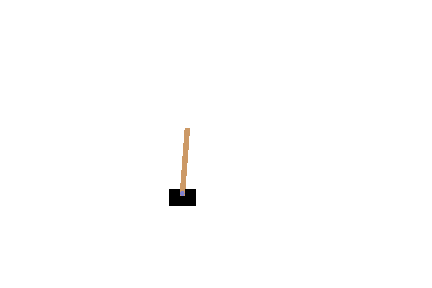
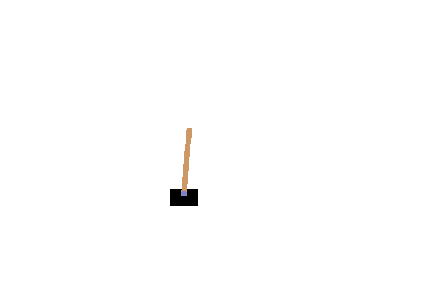
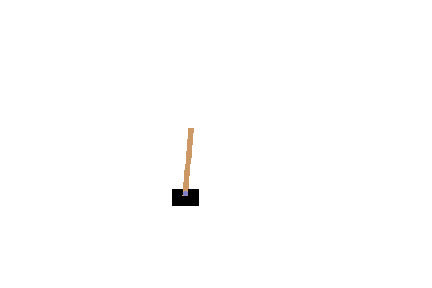

In [9]:
# evaluate trained agent
state = env.reset()
frames = []
t = 0
while True:
    frames.append(env.render(mode='rgb_array'))
    action = agent.act(discretize(state), greedy=True)
    state, _, done, _ = env.step(action)
    t += 1
    if done or t > 200:
        break
env.render(close=True)
display_frames_as_gif(frames)

Congratulation!! You've mastered simple Q learning agent!